In [12]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

In [2]:
train_dataset = MNIST(root=".", train=True, download=True, transform=ToTensor())
val_dataset = MNIST(root=".", train=False, download=True, transform=ToTensor())
len(train_dataset), len(val_dataset)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 63118687.28it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 21666194.57it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 65602597.17it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7515001.49it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



(60000, 10000)

In [3]:
train_dataset.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

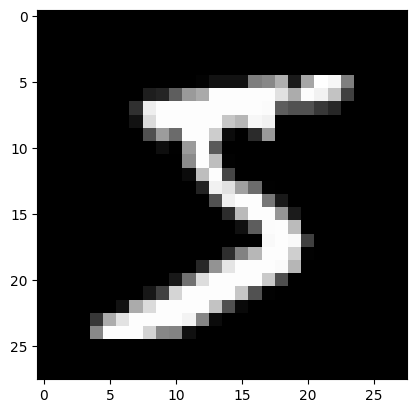

In [5]:
image, label = train_dataset[0]
plt.imshow(image[0], cmap="gray")

In [6]:
image.shape

torch.Size([1, 28, 28])

In [7]:
def add_noise(images):
    noisy_images = images + 0.3 * torch.randn(*images.shape)
    noisy_images = torch.clip(noisy_images, 0., 1.)
    return noisy_images

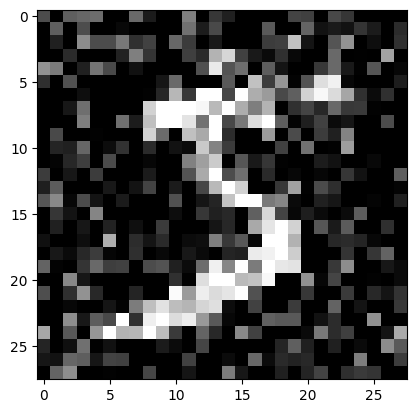

In [8]:
plt.imshow(add_noise(image)[0], cmap="gray")

In [27]:
class AutoencoderModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(28*28, 256),
      nn.ReLU(),
      nn.Linear(256, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 4)
    )

    self.decoder = nn.Sequential(
      nn.Linear(4, 32),
      nn.ReLU(),
      nn.Linear(32, 64),
      nn.ReLU(),
      nn.Linear(64, 256),
      nn.ReLU(),
      nn.Linear(256, 28*28),
      nn.Sigmoid()
    )

  def forward(self, X):
    enc = self.encoder(X)
    dec = self.decoder(enc)
    return dec

In [28]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)


In [36]:
EPOCHS = 20

model = AutoencoderModel()

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



for _ in range(EPOCHS):

  model.train()
  for x_train_batch, y_train_batch in train_loader:

    images = x_train_batch.view(x_train_batch.size(0), -1)
    noisy_images = add_noise(images)

    pred = model(noisy_images)

    loss = loss_fn(pred, images)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()



In [37]:
model.eval()
with torch.no_grad():
    for data in val_loader:
        images, _ = data
        images = images.view(images.size(0), -1)
        noisy_images = add_noise(images)
        outputs = model(noisy_images)
        break

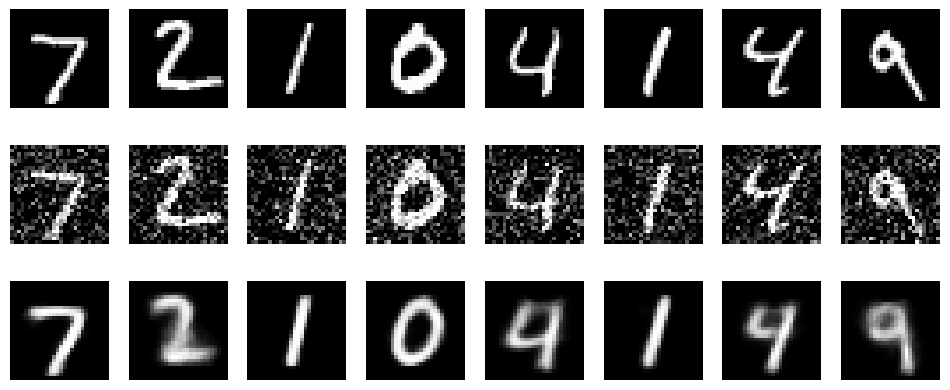

In [38]:
fig, axes = plt.subplots(3, 8, figsize=(12, 5))
for i in range(8):
    # Original images
    axes[0, i].imshow(images[i].reshape(28, 28).numpy(), cmap='gray')
    axes[0, i].axis('off')
    # Noisy images
    axes[1, i].imshow(noisy_images[i].view(28, 28).numpy(), cmap='gray')
    axes[1, i].axis('off')
    # Denoised images
    axes[2, i].imshow(outputs[i].view(28, 28).numpy(), cmap='gray')
    axes[2, i].axis('off')

plt.show()